In [85]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [86]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [87]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [89]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()



In [90]:
# Declare a Base using `automap_base()`
Base = automap_base()


# Use the Base class to reflect the database tables
Base.prepare(autoload_with= engine)



In [21]:
# Print all of the classes mapped to the Base

Base.classes.keys()


['station', 'measurement']

In [91]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [92]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [93]:

# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()




('2017-08-23',)

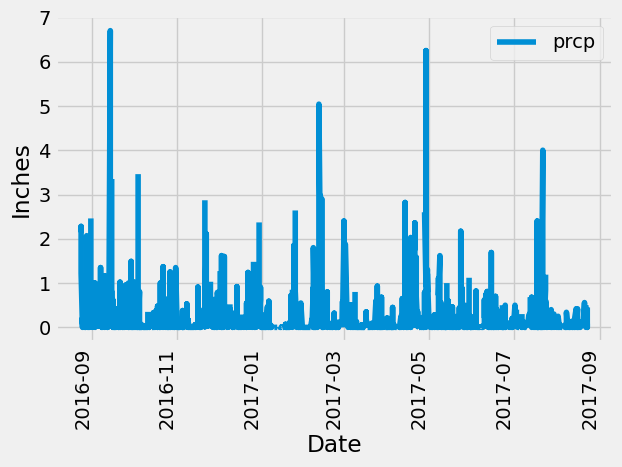

In [94]:
# # Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database.
most_recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date_row[0]

# Calculate the date one year from the last date in data set.

a_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= a_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
DF_query = pd.DataFrame(query, columns=['date' , 'prcp']) 


# Convert the date column to a datetime object
DF_query['date'] = pd.to_datetime(DF_query['date'])

# Sort the dataframe by date
DF_query.set_index('date', inplace=True)
DF_query.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

DF_query.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()





In [95]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = DF_query['prcp'].describe()

summary_stats







count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [96]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(Station.station).count()
total_stations




9

In [97]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(
    Measurement.station,func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [98]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = most_active_stations[0][0]

min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station_id).scalar()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station_id).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_id).scalar()

min_temp, max_temp, avg_temp


(54.0, 85.0, 71.66378066378067)

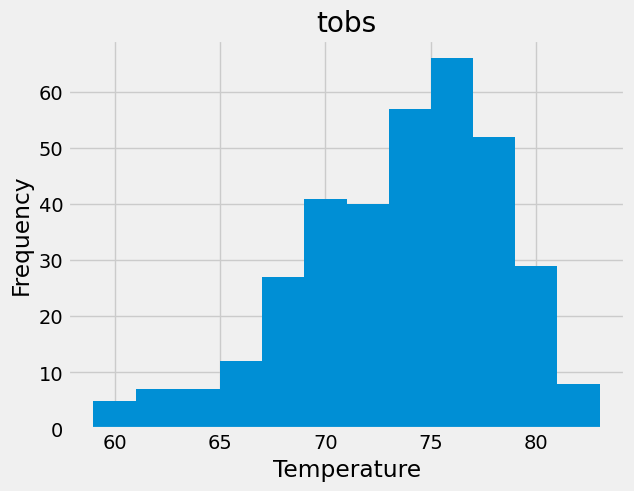

In [99]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the last 12 months of temperature observation data for this station
query_temp_data = session.query(Measurement.date, Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= a_year_ago
).all()

# Convert the query results to a Pandas DataFrame
temp_df = pd.DataFrame(query_temp_data, columns=['date', 'tobs'])


# Plot the results as a histogram
temp_df.hist(bins=12)

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()




# Close Session

In [100]:
# Close Session
session.close()
